Kevin Yee Yew Wai (1002681)
Samson Yu Bai Jian (1002819)

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional
import torch.optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support
from torch.utils.data.sampler import SubsetRandomSampler

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output

import numpy as np
import collections
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [2]:
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

#training batch size
batch_size=8
#validation batch size
valbatch_size=8

indices = list(range(len(train_set)))
train_indices, val_indices = indices[:50000], indices[50000:]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, sampler=train_sampler)

val_loader = torch.utils.data.DataLoader(
        train_set, batch_size=valbatch_size, sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=valbatch_size, sampler=None)

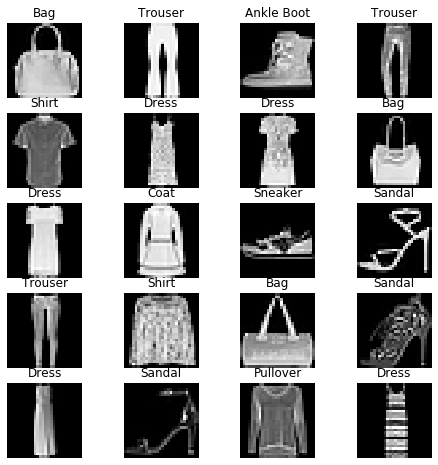

In [3]:
# Visualize data
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [4]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers    
    self.fc1 = nn.Linear(in_features=1*28*28, out_features=300)
    self.fc2 = nn.Linear(in_features=300, out_features=100)
    self.out = nn.Linear(in_features=100, out_features=10)

  # define forward function
  def forward(self, t):
    # Use view() to get [batch_size, num_features].
    # -1 calculates the missing value given the other dim.
    t = t.view(batch_size, -1) # torch.Size([1, 784])
    # fc1
    t = self.fc1(t)
    t = torch.nn.functional.relu(t)

    # fc2
    t = self.fc2(t)
    t = torch.nn.functional.relu(t)

    # output
    t = torch.nn.functional.log_softmax(self.out(t), dim=1)
    # don't need softmax here since we'll use cross-entropy as activation.

    return t

def train_epoch(model,  trainloader,  criterion, device, optimizer ):
    
    model.train() 
    
    # Total loss / Total correct
    total_loss = 0.0   
    total_correct = 0
    
    for batch_idx, data in enumerate(trainloader):
        inputs=data[0].to(device)
        labels=data[1].to(device) 
        
        # zero_grad clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls)
        optimizer.zero_grad()
        
        # calculate and add correct predictions vs labels
        outputs = model(inputs) 
        cpuout= outputs.to('cpu')                  
        _, preds = torch.max(cpuout, 1) 
        total_correct += torch.sum(preds == labels.data)
        
        # add loss
        loss = criterion(outputs, labels)     
        total_loss += loss
        
        # loss.backward() computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
        loss.backward()            
        optimizer.step()         
            
    total_size = trainloader.__len__()*trainloader.batch_size*1.0    
    acc = total_correct.double() / total_size
    avg_loss = total_loss / (trainloader.__len__()*1.0)
    
    return acc.item(), avg_loss.item()

def evaluate(model, dataloader, criterion, device):   
    
    model.eval()

    total_loss = 0.0   
    total_correct = 0
    
    with torch.no_grad():
      for ctr, data in enumerate(dataloader):
#           print ('epoch at 10000', ctr)            
          inputs = data[0].to(device) 
          labels = data[1] 
          
          # calculate and add correct predictions vs labels  
          outputs = model(inputs)  
          cpuout= outputs.to('cpu')            
          _, preds = torch.max(cpuout, 1)
          total_correct += torch.sum(preds == labels.data)  
          
          # add loss
          loss = criterion(outputs, labels)          
          total_loss += loss          
      
      total_size = dataloader.__len__()*dataloader.batch_size*1.0
      acc = total_correct.double() / total_size # this does not work if one uses a datasampler!!!
      avg_loss = total_loss / (dataloader.__len__()*1.0)
    
    return acc.item(), avg_loss.item() 


def train_modelcv(dataloader_cvtrain, dataloader_cvval, dataloader_cvtest ,  model ,  criterion, optimizer, scheduler, num_epochs, device):

  graph_data = collections.defaultdict(list)
  bestweights = 0  
  best_val_loss = 100000000000
  best_epoch =-1

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))    

    model.train(True)    
    train_acc, train_loss = train_epoch(model,  dataloader_cvtrain,  criterion,  device , optimizer )    
    #scheduler.step()         

    model.train(False)
    val_acc, val_loss = evaluate(model, dataloader_cvval, criterion, device)    
    
    # IMPORTANT NOTE: I assumed that the instructions in the homework means that it is
    #                 INCORRECT to use the test dataset as the validation dataset. Hence,
    #                 I correctly use the validation dataset.      
    # Choosing the model that gives the best validation loss    
    if val_loss < best_val_loss: #higher is better or lower is better? lower is better
      bestweights= model.state_dict()
      best_val_loss = val_loss
      best_epoch = epoch    
    
    print('Current val_loss:', val_loss, ', Current best_val_loss:', best_val_loss, ' at epoch ', best_epoch)
    print('-' * 10)
    
    model.load_state_dict(bestweights) 
    
    test_acc, test_loss = evaluate(model, dataloader_cvtest, criterion, device)        
    
    graph_data['train_acc'].append(train_acc)
    graph_data['train_loss'].append(train_loss)
    graph_data['val_acc'].append(val_acc)
    graph_data['val_loss'].append(val_loss)
    graph_data['test_acc'].append(test_acc)
    graph_data['test_loss'].append(test_loss)
    
  return graph_data

def plot_graphs(maxnumepochs, graph_data, learning_rate):
    plt.figure(figsize=(12,6))

    plt.subplot(121)
    plt.title('Acc vs Epoch [learning rate:{}]'.format(learning_rate))
    plt.plot(list(range(maxnumepochs)), graph_data['train_acc'], label='train_acc')
    plt.plot(list(range(maxnumepochs)), graph_data['val_acc'], label='val_acc')
    plt.plot(list(range(maxnumepochs)), graph_data['test_acc'], label='test_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()

    plt.subplot(122)
    plt.title('Loss vs Epoch [learning rate:{}]'.format(learning_rate))
    plt.plot(list(range(maxnumepochs)), graph_data['train_loss'], label='train_loss')
    plt.plot(list(range(maxnumepochs)), graph_data['val_loss'], label='val_loss')
    plt.plot(list(range(maxnumepochs)), graph_data['test_loss'], label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    fname = 'graph_lr_{}.png'.format(learning_rate)
    
    plt.savefig(fname, bbox_inches='tight')

    plt.show()

def run(learning_rate):
    model = Network()  

    # negative log likelihood loss
    criterion = torch.nn.NLLLoss()
    
    # number of epoch
    maxnumepochs = 20
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate, momentum=0.0, weight_decay=0)

    device=torch.device('cpu')
    graph_data = train_modelcv(dataloader_cvtrain = train_loader,                                                          dataloader_cvval = val_loader,  
                               dataloader_cvtest = test_loader,
                               model = model,
                               criterion = criterion,
                               optimizer = optimizer,
                               scheduler = None,
                               num_epochs = maxnumepochs,
                               device = device)    
    plot_graphs(maxnumepochs, graph_data, learning_rate)  

Epoch 0/19
Current val_loss: 0.5304825305938721 , Current best_val_loss: 0.5304825305938721  at epoch  0
----------
Epoch 1/19
Current val_loss: 0.45642906427383423 , Current best_val_loss: 0.45642906427383423  at epoch  1
----------
Epoch 2/19
Current val_loss: 0.4321119487285614 , Current best_val_loss: 0.4321119487285614  at epoch  2
----------
Epoch 3/19
Current val_loss: 0.36952269077301025 , Current best_val_loss: 0.36952269077301025  at epoch  3
----------
Epoch 4/19
Current val_loss: 0.370060533285141 , Current best_val_loss: 0.36952269077301025  at epoch  3
----------
Epoch 5/19
Current val_loss: 0.363400399684906 , Current best_val_loss: 0.363400399684906  at epoch  5
----------
Epoch 6/19
Current val_loss: 0.34289857745170593 , Current best_val_loss: 0.34289857745170593  at epoch  6
----------
Epoch 7/19
Current val_loss: 0.33148637413978577 , Current best_val_loss: 0.33148637413978577  at epoch  7
----------
Epoch 8/19
Current val_loss: 0.3496699929237366 , Current best_val

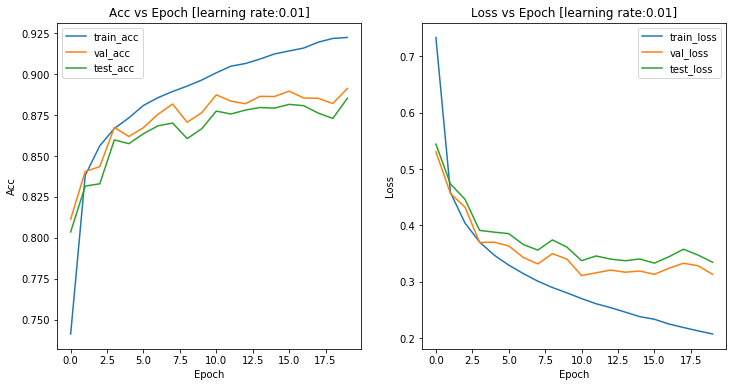

In [5]:
# learning rate 1 = 0.01
learning_rate=0.01
# Run model
run(learning_rate)  

Epoch 0/19
Current val_loss: 0.9820139408111572 , Current best_val_loss: 0.9820139408111572  at epoch  0
----------
Epoch 1/19
Current val_loss: 0.7346292734146118 , Current best_val_loss: 0.7346292734146118  at epoch  1
----------
Epoch 2/19
Current val_loss: 0.6302408576011658 , Current best_val_loss: 0.6302408576011658  at epoch  2
----------
Epoch 3/19
Current val_loss: 0.5718416571617126 , Current best_val_loss: 0.5718416571617126  at epoch  3
----------
Epoch 4/19
Current val_loss: 0.5342007279396057 , Current best_val_loss: 0.5342007279396057  at epoch  4
----------
Epoch 5/19
Current val_loss: 0.5115892887115479 , Current best_val_loss: 0.5115892887115479  at epoch  5
----------
Epoch 6/19
Current val_loss: 0.49833184480667114 , Current best_val_loss: 0.49833184480667114  at epoch  6
----------
Epoch 7/19
Current val_loss: 0.47939780354499817 , Current best_val_loss: 0.47939780354499817  at epoch  7
----------
Epoch 8/19
Current val_loss: 0.47562891244888306 , Current best_val_

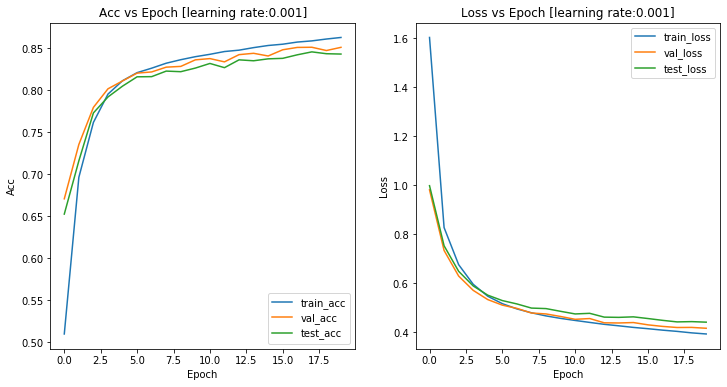

In [6]:
# learning rate 2 = 0.001
learning_rate=0.001
# Run model
run(learning_rate)